In [ ]:
import pandas as pd

In [ ]:
treino_1 = pd.read_csv('ex_1.csv')
treino_9 = pd.read_csv('ex_9.csv')
treino_20 = pd.read_csv('ex_20.csv')
treino_21 = pd.read_csv('ex_21.csv')
treino_23 = pd.read_csv('ex_23.csv')
treino_24 = pd.read_csv('ex_24.csv')
treino = pd.concat([treino_1, treino_9, treino_20, treino_21, treino_23, treino_24], ignore_index=True)
display(treino)

,time,input_voltage,el_power
0,810.07028,10.0,1228.791720
1,811.06938,10.0,1223.041745
2,812.06848,10.0,1244.960866
3,813.06758,10.0,1229.259058
4,814.06668,10.0,1248.117024
...,...,...,...
52935,10574.74000,3.0,1180.509030
52936,10575.96000,3.0,1085.497428
52937,10577.16000,3.0,1184.384535
52938,10578.40000,3.0,1082.038939


In [ ]:
teste_4 = pd.read_csv('ex_4.csv')
teste_22 = pd.read_csv('ex_22.csv')
teste = pd.concat([teste_4, teste_22], ignore_index=True)
display(teste)

,time,input_voltage,el_power
0,758.425813,3.0,1206.993434
1,759.425109,3.0,1255.072122
2,760.424406,3.0,1203.093254
3,761.423702,3.0,1259.000662
4,762.422998,3.0,1196.033782
...,...,...,...
18280,10423.460000,3.0,1048.518297
18281,10424.500000,3.0,1131.068059
18282,10425.540000,3.0,1044.663337
18283,10426.580000,3.0,1129.408052


In [ ]:
import pymc as pm

time = treino['time'].values
input_voltage = treino['input_voltage'].values
el_power = treino['el_power'].values

In [ ]:
with pm.Model() as multi_linreg:

    alpha = pm.Normal('alpha', 0, 1000)
    beta_time = pm.Normal('beta_time', 0, 1000)
    beta_i_voltage = pm.Normal('beta_i_voltage', 0, 10)
    epsilon = pm.HalfNormal('epsilon', 100)

    mu = alpha + beta_time * time + beta_i_voltage * input_voltage

    Y_obs = pm.Normal('Y_obs', mu, epsilon, observed=el_power)

In [ ]:
with multi_linreg:
  trace = pm.sample()

pm.summary(trace)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,425.529,4.313,417.399,433.783,0.128,0.121,1133.0,975.0,1.0
beta_i_voltage,246.692,0.593,245.628,247.866,0.018,0.017,1127.0,728.0,1.0
beta_time,0.011,0.001,0.010,0.012,0.000,0.000,1545.0,990.0,1.0
epsilon,339.220,1.057,337.171,341.077,0.027,0.027,1544.0,1227.0,1.0


In [ ]:
with multi_linreg:
    trace_post = pm.sample_posterior_predictive(trace)

Output()

In [ ]:
with pm.Model() as multi_linreg_robust:

    alpha = pm.Normal('alpha', 0, 1000)
    beta_time = pm.Normal('beta_time', 0, 1000)
    beta_i_voltage = pm.Normal('beta_i_voltage', 0, 10)
    sigma = pm.HalfNormal('sigma', 1000)

    mu = alpha + beta_time * time + beta_i_voltage * input_voltage
    df = pm.Exponential("df",1)
    Y_obs = pm.StudentT('Y_obs', nu=df, mu=mu, sigma=sigma, observed=el_power)

In [ ]:
with multi_linreg_robust:
  trace_robust = pm.sample()

pm.summary(trace_robust)

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,286.309,1.254,284.008,288.720,0.035,0.036,1261.0,863.0,1.0
beta_i_voltage,289.887,0.181,289.550,290.227,0.005,0.004,1253.0,1002.0,1.0
beta_time,-0.011,0.000,-0.011,-0.011,0.000,0.000,1507.0,1161.0,1.0
df,1.415,0.012,1.392,1.438,0.000,0.000,1631.0,1486.0,1.0
sigma,81.179,0.499,80.206,82.057,0.013,0.009,1470.0,1589.0,1.0


In [ ]:
with multi_linreg_robust:
    trace_post_t = pm.sample_posterior_predictive(trace_robust)

Output()

In [ ]:
with multi_linreg:
    pm.compute_log_likelihood(trace)

with multi_linreg_robust:
    pm.compute_log_likelihood(trace_robust)

Output()

Output()

In [ ]:
import arviz as az
import matplotlib.pyplot as plt

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

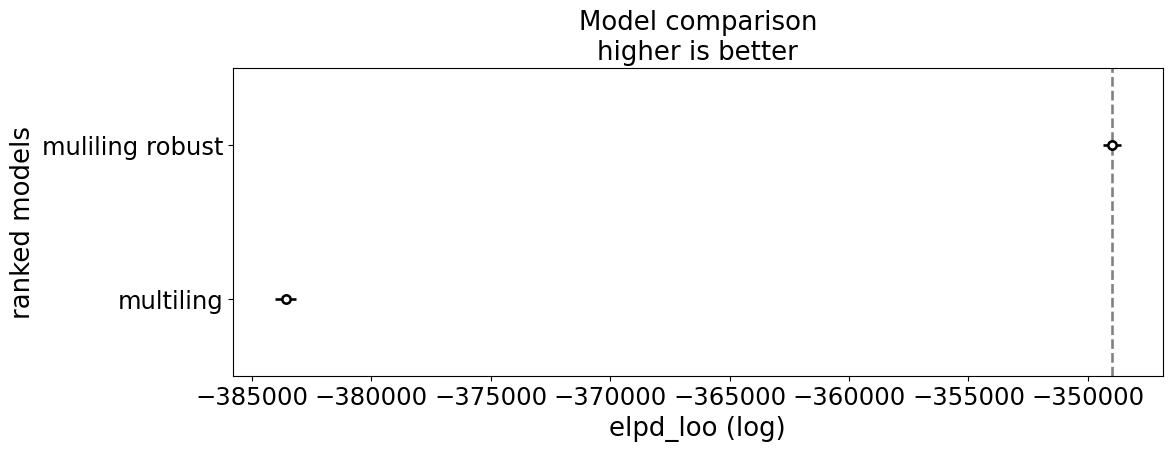

In [ ]:
model_compare = az.compare(
    {
        "multiling": trace,
        "muliling robust": trace_robust,
    }, method='BB-pseudo-BMA'
)
az.plot_compare(model_compare, figsize=(12, 4), insample_dev=False)

In [ ]:
model_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
muliling robust,0,-348996.835699,5.460140,0.000000,1.0,362.346589,0.000000,False,log
multiling,1,-383591.347291,10.037323,34594.511591,0.0,439.538868,262.803772,False,log


modelo multilinear com regressão robusta se mostrou o melhor entre eles, então iremos seguir com ele para o conjunto de teste

In [ ]:
time_teste = teste['time'].values
input_voltage_teste = teste['input_voltage'].values
el_power_teste = teste['el_power'].values

In [ ]:
with pm.Model() as multi_linreg_robust_mutable:
    t_m = pm.MutableData('t_m', time)
    i_m = pm.MutableData('i_m', input_voltage)
    y = pm.MutableData('y_m', el_power)
    alpha = pm.Normal('alpha', 0, 1000)
    beta_time = pm.Normal('beta_time', 0, 1000)
    beta_i_voltage = pm.Normal('beta_i_voltage', 0, 10)
    sigma = pm.HalfNormal('sigma', 1000)

    mu = alpha + beta_time * t_m + beta_i_voltage * i_m
    df = pm.Exponential("df",1)
    Y_obs = pm.StudentT('Y_obs', nu=df, mu=mu, sigma=sigma, observed=y)

/usr/local/lib/python3.11/dist-packages/pymc/data.py:265: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


In [ ]:
with multi_linreg_robust_mutable:
  trace_robust_multable = pm.sample()


Output()

In [ ]:
with multi_linreg_robust_mutable:

    pm.set_data({
        "t_m": time_teste,
        "i_m": input_voltage_teste,
        "y_m": el_power_teste})

In [ ]:
with multi_linreg_robust_mutable:
    ppc = pm.sample_posterior_predictive(trace_robust_multable)

Output()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_percentage_error
import numpy as np
el_power_teste = teste['el_power'].values

el_power_predictive = ppc.posterior_predictive["Y_obs"].mean(["chain","draw"]).to_numpy()

mae = mean_absolute_error(el_power_teste,el_power_predictive)
mse = mean_squared_error(el_power_teste, el_power_predictive)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(el_power_teste, el_power_predictive)
relative_error = mae / np.mean(el_power_teste)
print(f"MAE: {mae}")
print(f"MAPE: {mape*100:.2f}%")
print(f"RMSE: {rmse}")
print(f"Erro relativo (MAE / média dos valores reais): {relative_error}")

MAE: 214.19437633858323
MAPE: 11.34%
RMSE: 481.5012042354965
Erro relativo (MAE / média dos valores reais): 0.10949054612098988


# **Consideração final**
O modelo apresentou um desempenho razoável. Apesar de ser robusto a outliers, o RMSE ainda é influenciado por alguns pontos com erros maiores, indicando que, em determinados momentos, o modelo não capturou bem as variações mais acentuadas. Por outro lado, o MAPE e o erro relativo, ambos em torno de 11%, sugerem que a maior parte das previsões está relativamente próxima dos valores reais. Isso indica que, na maioria dos casos, o modelo se ajusta bem ao comportamento geral dos dados, e os desvios mais significativos estão restritos a alguns casos específicos